In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

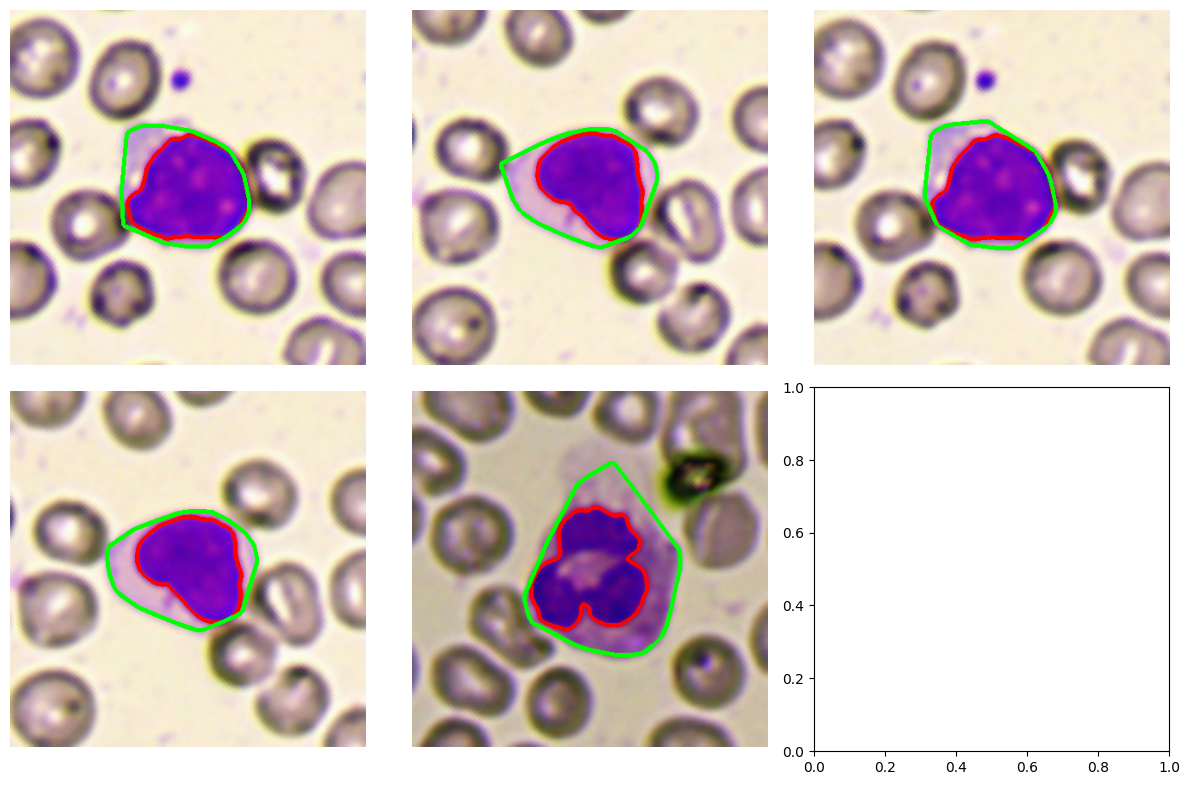

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

input_path = "C:\\Users\\krrah\\Downloads\\Dewinter2023\\Final_yolov5x\\Red_images_sample"

processed_image_red = []
Cyto_area = []
Cyto_Perimeter = []
# Iterate over the images in the folder
for filename in os.listdir(input_path):
    if filename.endswith(".jpg"):
        image_path = os.path.join(input_path, filename)

        # Read the image
        image = cv2.imread(image_path)
        image_copy = image.copy()
        # Define the RGB to CMYK conversion function

        def select_center_contour(contours):
            if len(contours) == 0:
                return None

            # Compute the areas of all contours
            contour_areas = [cv2.contourArea(contour) for contour in contours]

            # Find the index of the contour with the largest area
            max_area_index = np.argmax(contour_areas)

            # Return the contour with the largest area
            center_contour = contours[max_area_index]

            return center_contour

        def bgr_to_cmyk(bgr):
            b, g, r = bgr/255.0
            b, g, r = b/255.0, g/255.0, r/255.0
            k = 1 - np.max([b, g, r])
            if k == 1:
                c = m = y = 0
            else:
                c = (1 - r - k) / (1 - k)
                m = (1 - g - k) / (1 - k)
                y = (1 - b - k) / (1 - k)
            return np.array([c, m, y, k])

        # Apply the RGB to CMYK conversion to each pixel using a lambda function
        cmyk_img = np.apply_along_axis(
            lambda x: bgr_to_cmyk(x), axis=2, arr=image)
        cmyk_img_copy = cmyk_img.copy()
        # plt.imshow(cmyk_img)
        # Scale the values in the CMYK image to the range 0-255
        cmyk_img = (cmyk_img*255).astype(np.uint8)

        pixels = cmyk_img.reshape(-1, 4)
        pixels = np.float32(pixels)
        # Define the criteria for K-means clustering (maximum iterations and epsilon)
        criteria = (cv2.TERM_CRITERIA_EPS +
                    cv2.TERM_CRITERIA_MAX_ITER, 100, 0.9)

        # Perform K-means clustering
        k = 5  # Number of clusters
        _, labels, centers = cv2.kmeans(
            pixels, k, None, criteria, 100, cv2.KMEANS_RANDOM_CENTERS)

        # Convert the centers to unsigned integers
        centers = np.uint8(centers)
        # Map the labels to the centers
        segmented_image = centers[labels.flatten()]

        # Reshape the segmented image back to the original shape
        segmented_image = segmented_image.reshape(cmyk_img.shape)

        cv2.imwrite("segmented_image.jpg", segmented_image)
        # Apply the RGB to CMYK conversion to each pixel using a lambda function
        bgr_img = cv2.imread("segmented_image.jpg")

        # Convert the bgr image to HSV
        segmented_HSV = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
        # convert to gray scale image
        segmented_image_gray = cv2.cvtColor(
            segmented_image, cv2.COLOR_BGR2GRAY)
        # Set the threshold value (adjust as needed)

        _, segmented_mask = cv2.threshold(
            segmented_image_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        # Invert the binary image using bitwise_not()
        inverted_image = cv2.bitwise_not(segmented_mask)
        contours, _ = cv2.findContours(
            inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = select_center_contour(contours)
        cv2.drawContours(image_copy, [contours], -1, (0, 0, 255), 3)

        def smooth_contour(contour, epsilon):
            # Convert the contour to a numpy array
            contour = np.squeeze(contour)

            # Reshape the contour to fit the required format for cv2.approxPolyDP
            contour = contour.reshape((-1, 1, 2))

            # Apply the Douglas-Peucker algorithm for contour approximation
            smoothed_contour = cv2.approxPolyDP(contour, epsilon, True)

            return smoothed_contour
        H, S, V = cv2.split(segmented_HSV)

        # Apply thresholding to the H  Channel
        kernel = np.ones((3, 3), np.uint8)
        _, thresholded_image = cv2.threshold(H, 30, 255, cv2.THRESH_BINARY)

        # Define the kernel for erosion and dilation
        kernel = np.ones((5, 5), np.uint8)
        # cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)
        segmented_mask = cv2.erode(thresholded_image, kernel, iterations=2)
        segmented_mask = cv2.morphologyEx(
            segmented_mask, cv2.MORPH_OPEN, kernel, iterations=1)

        contours, _ = cv2.findContours(
            segmented_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = select_center_contour(contours)
        contour_areas = [cv2.contourArea(contour) for contour in contours]
        # Find the index of the contour with the largest area
        max_area_index = np.argmax(contour_areas)
        # Choose the index of the contour you want to smoothen

        # Set the epsilon value for contour smoothing (adjust as needed)
        epsilon = 0.009 * cv2.arcLength(contours[max_area_index], True)
        contours = smooth_contour(contours, epsilon)
        contours = cv2.convexHull(contours)
        cv2.drawContours(image_copy, [contours], -1, (0, 255, 0), 3)

        area = contour_areas[max_area_index]
        # peri = contour_perimeter[max_peri_index]
        Cyto_area.append(area)
        # Cyto_Perimeter.append(peri)
        processed_image_red.append(image_copy)

# Create a grid for displaying the images
grid_rows = int(np.ceil(len(processed_image_red) / 3))
fig, axes = plt.subplots(grid_rows, 3, figsize=(12, 4 * grid_rows))

# Iterate over the processed images and display them in the grid
for i, image_x in enumerate(processed_image_red):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(cv2.cvtColor(image_x, cv2.COLOR_BGR2RGB))
    axes[row, col].axis('off')

# Adjust the layout and display the grid
plt.tight_layout()
plt.show()



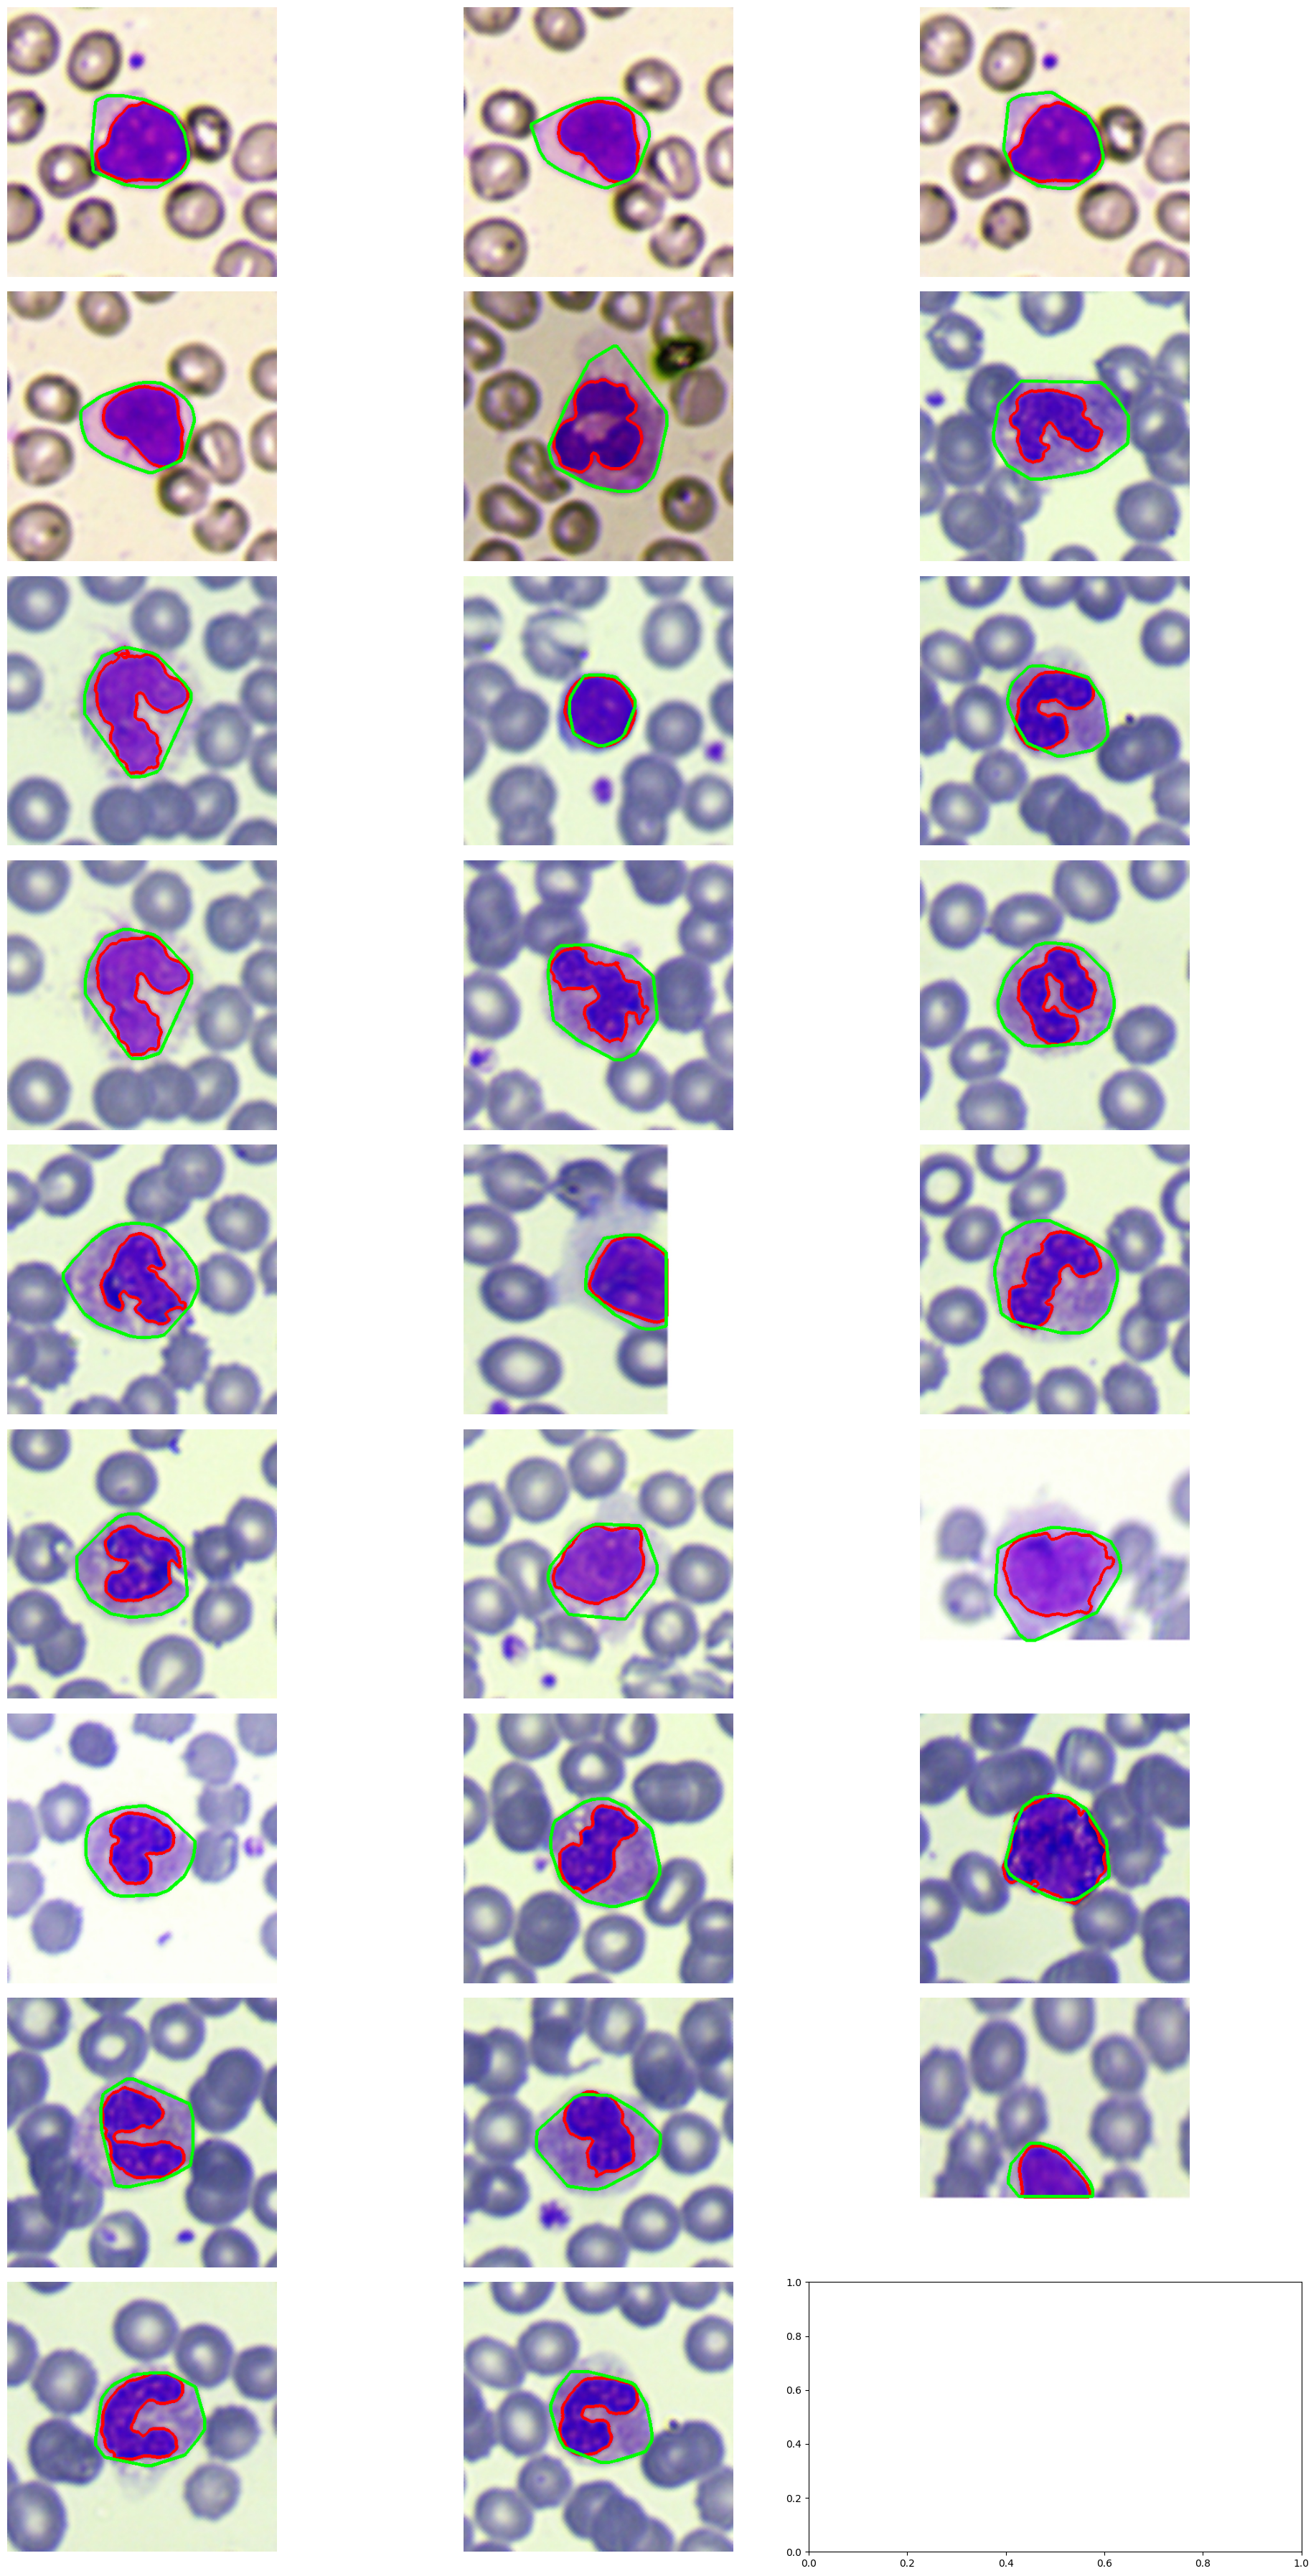

In [3]:


input_path = "C:\\Users\\krrah\\Downloads\\Dewinter2023\\Final_yolov5x\\blue_images_sample"

processed_image_blue = []
Cyto_area = []
Cyto_Perimeter = []
# Iterate over the images in the folder
for filename in os.listdir(input_path):
    if filename.endswith(".jpg"):
        image_path = os.path.join(input_path, filename)

       # Read the image
        image = cv2.imread(image_path)
        image_copy = image.copy()

        # plt.imshow(blurM)

        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        img_hsv = cv2.cvtColor(lab, cv2.COLOR_BGR2HSV)

        # Define the lower and upper bounds for the green color in the HSV color space
        lower_green = np.array([40, 130, 170])
        upper_green = np.array([90, 255, 255])

        # Threshold the HSV image based on the color range
        img_mask = cv2.inRange(img_hsv, lower_green, upper_green)

        # Find contours in the thresholded image
        contours, _ = cv2.findContours(
            img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        def select_center_contour(contours):
            if len(contours) == 0:
                return None

            # Compute the areas of all contours
            contour_areas = [cv2.contourArea(contour) for contour in contours]

            # Find the index of the contour with the largest area
            max_area_index = np.argmax(contour_areas)

            # Return the contour with the largest area
            center_contour = contours[max_area_index]

            return center_contour
        nucleus_contour = select_center_contour(contours)
        cv2.drawContours(image_copy, [nucleus_contour], -1, (0, 0, 255), 3)

        pixels = image.reshape(-1, 3)
        pixels = np.float32(pixels)
        # Define the criteria for K-means clustering (maximum iterations and epsilon)
        criteria = (cv2.TERM_CRITERIA_EPS +
                    cv2.TERM_CRITERIA_MAX_ITER, 100, 0.5)

        # Perform K-means clustering
        k = 7  # Number of clusters
        _, labels, centers = cv2.kmeans(
            pixels, k, None, criteria, 100, cv2.KMEANS_RANDOM_CENTERS)

        # Convert the centers to unsigned integers
        centers = np.uint8(centers)
        # Map the labels to the centers
        segmented_image = centers[labels.flatten()]

        # Reshape the segmented image back to the original shape
        segmented_image = segmented_image.reshape(image.shape)

        # Convert the segmented image to grayscale
        segmented_image_gray = cv2.cvtColor(
            segmented_image, cv2.COLOR_RGB2GRAY)

        # Threshold the grayscale image
        _, segmented_mask = cv2.threshold(
            segmented_image_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

        # Apply the segmented mask to the original image
        segmented_result = cv2.bitwise_and(
            image_copy, image_copy, mask=segmented_mask)

        def smooth_contour(contour, epsilon):
            # Convert the contour to a numpy array
            contour = np.squeeze(contour)

            # Reshape the contour to fit the required format for cv2.approxPolyDP
            contour = contour.reshape((-1, 1, 2))

            # Apply the Douglas-Peucker algorithm for contour approximation
            smoothed_contour = cv2.approxPolyDP(contour, epsilon, True)

            return smoothed_contour
        mask = np.zeros(segmented_mask.shape[:2], dtype="uint8")
        segmented_copy = segmented_result.copy()
        # contours, _ = cv2.findContours(contour_portion,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        segmented_HSV = cv2.cvtColor(segmented_result, cv2.COLOR_BGR2HSV)
        H, S, V = cv2.split(segmented_HSV)
        kernel = np.ones((10, 10), np.uint8)
        _, thresholded_image = cv2.threshold(H, 128, 255, cv2.THRESH_BINARY)
        # Perform morphological closing to fill holes
        filled_image = cv2.morphologyEx(
            thresholded_image, cv2.MORPH_CLOSE, kernel)
        kernel = np.ones((10, 10), np.uint8)
        # Perform morphological opening to remove small dust particles
        opened_image = cv2.morphologyEx(filled_image, cv2.MORPH_OPEN, kernel)
        contours_cyto, _ = cv2.findContours(
            opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Select the center contour

        contour_areas = [cv2.contourArea(contour) for contour in contours_cyto]
        contour_perimeter = [cv2.arcLength(
            contour, True) for contour in contours_cyto]
        # Find the index of the contour with the largest area
        max_area_index = np.argmax(contour_areas)
        max_peri_index = np.argmax(contour_perimeter)
        area = contour_areas[max_area_index]
        peri = contour_perimeter[max_peri_index]
        convex_cyto = cv2.convexHull(contours_cyto[max_area_index])
        Cyto_area.append(area)
        Cyto_Perimeter.append(peri)
        processed_image_blue.append(image_copy)
        cv2.drawContours(image_copy, [convex_cyto], -1, (0, 255, 0), 3)
processed_image = processed_image_red + processed_image_blue
# Create a grid for displaying the images
grid_rows = int(np.ceil(len(processed_image) / 3))
fig, axes = plt.subplots(grid_rows, 3, figsize=(20, 4 * grid_rows))

# Iterate over the processed images and display them in the grid
for i, image_x in enumerate(processed_image):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(cv2.cvtColor(image_x, cv2.COLOR_BGR2RGB))
    axes[row, col].axis('off')

# Adjust the layout and display the grid
plt.tight_layout()
plt.show()

New Features to work upon
1. Eccentricity
2. Mean and standard Deviation of individual channel in HSV COLORSPACE
3. Number of lobes
4. Features obtained from histogram of an object using region of interest
5. statistical moments of the gray level histogram 
6. statistical moments of the boundary or area 
7. Mean Axis length
8. textural features are obtained through the grey level co-occurrence
matrix method (GLCM)

Postprocessing step to detect the cytoplasm

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

input_path = "C:\\Users\\krrah\\Downloads\\Dewinter2023\\Final_yolov5x\\Red_images_sample"

processed_image_red = []
Cyto_area = []
Cyto_Perimeter = []
# Iterate over the images in the folder
for filename in os.listdir(input_path):
    if filename.endswith(".jpg"):
        image_path = os.path.join(input_path, filename)

        # Read the image
        image = cv2.imread(image_path)
        image_copy = image.copy()
        # Define the RGB to CMYK conversion function

        def select_center_contour(contours):
            if len(contours) == 0:
                return None

            # Compute the areas of all contours
            contour_areas = [cv2.contourArea(contour) for contour in contours]

            # Find the index of the contour with the largest area
            max_area_index = np.argmax(contour_areas)

            # Return the contour with the largest area
            center_contour = contours[max_area_index]

            return center_contour

        def bgr_to_cmyk(bgr):
            b, g, r = bgr/255.0
            b, g, r = b/255.0, g/255.0, r/255.0
            k = 1 - np.max([b, g, r])
            if k == 1:
                c = m = y = 0
            else:
                c = (1 - r - k) / (1 - k)
                m = (1 - g - k) / (1 - k)
                y = (1 - b - k) / (1 - k)
            return np.array([c, m, y, k])

        # Apply the RGB to CMYK conversion to each pixel using a lambda function
        cmyk_img = np.apply_along_axis(
            lambda x: bgr_to_cmyk(x), axis=2, arr=image)
        cmyk_img_copy = cmyk_img.copy()
        # plt.imshow(cmyk_img)
        # Scale the values in the CMYK image to the range 0-255
        cmyk_img = (cmyk_img*255).astype(np.uint8)

        pixels = cmyk_img.reshape(-1, 4)
        pixels = np.float32(pixels)
        # Define the criteria for K-means clustering (maximum iterations and epsilon)
        criteria = (cv2.TERM_CRITERIA_EPS +
                    cv2.TERM_CRITERIA_MAX_ITER, 100, 0.9)

        # Perform K-means clustering
        k = 5  # Number of clusters
        _, labels, centers = cv2.kmeans(
            pixels, k, None, criteria, 100, cv2.KMEANS_RANDOM_CENTERS)

        # Convert the centers to unsigned integers
        centers = np.uint8(centers)
        # Map the labels to the centers
        segmented_image = centers[labels.flatten()]

        # Reshape the segmented image back to the original shape
        segmented_image = segmented_image.reshape(cmyk_img.shape)

        cv2.imwrite("segmented_image.jpg", segmented_image)
        # Apply the RGB to CMYK conversion to each pixel using a lambda function
        bgr_img = cv2.imread("segmented_image.jpg")

        # Convert the bgr image to HSV
        segmented_HSV = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
        # convert to gray scale image
        segmented_image_gray = cv2.cvtColor(
            segmented_image, cv2.COLOR_BGR2GRAY)
        # Set the threshold value (adjust as needed)

        _, segmented_mask = cv2.threshold(
            segmented_image_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        # Invert the binary image using bitwise_not()
        inverted_image = cv2.bitwise_not(segmented_mask)
        contours, _ = cv2.findContours(
            inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = select_center_contour(contours)
        cv2.drawContours(image_copy, [contours], -1, (0, 0, 255), 3)

        def smooth_contour(contour, epsilon):
            # Convert the contour to a numpy array
            contour = np.squeeze(contour)

            # Reshape the contour to fit the required format for cv2.approxPolyDP
            contour = contour.reshape((-1, 1, 2))

            # Apply the Douglas-Peucker algorithm for contour approximation
            smoothed_contour = cv2.approxPolyDP(contour, epsilon, True)

            return smoothed_contour
        H, S, V = cv2.split(segmented_HSV)

        # Apply thresholding to the H  Channel
        kernel = np.ones((3, 3), np.uint8)
        _, thresholded_image = cv2.threshold(H, 30, 255, cv2.THRESH_BINARY)

        # Define the kernel for erosion and dilation
        kernel = np.ones((5, 5), np.uint8)
        # cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)
        segmented_mask = cv2.erode(thresholded_image, kernel, iterations=2)
        segmented_mask = cv2.morphologyEx(
            segmented_mask, cv2.MORPH_OPEN, kernel, iterations=1)

        contours, _ = cv2.findContours(
            segmented_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = select_center_contour(contours)
        contour_areas = [cv2.contourArea(contour) for contour in contours]
        # Find the index of the contour with the largest area
        max_area_index = np.argmax(contour_areas)
        # Choose the index of the contour you want to smoothen

        # Set the epsilon value for contour smoothing (adjust as needed)
        epsilon = 0.009 * cv2.arcLength(contours[max_area_index], True)
        contours = smooth_contour(contours, epsilon)
        contours = cv2.convexHull(contours)
        cv2.drawContours(image_copy, [contours], -1, (0, 255, 0), 3)

        area = contour_areas[max_area_index]
        # peri = contour_perimeter[max_peri_index]
        Cyto_area.append(area)
        # Cyto_Perimeter.append(peri)
        processed_image_red.append(image_copy)

# Create a grid for displaying the images
grid_rows = int(np.ceil(len(processed_image_red) / 3))
fig, axes = plt.subplots(grid_rows, 3, figsize=(12, 4 * grid_rows))

# Iterate over the processed images and display them in the grid
for i, image_x in enumerate(processed_image_red):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(cv2.cvtColor(image_x, cv2.COLOR_BGR2RGB))
    axes[row, col].axis('off')

# Adjust the layout and display the grid
plt.tight_layout()
plt.show()

#-----------------------------------------------------------    For blue images  ---------------------------------------------

input_path = "C:\\Users\\krrah\\Downloads\\Dewinter2023\\Final_yolov5x\\blue_images_sample"

processed_image_blue = []
Cyto_area = []
Cyto_Perimeter = []
# Iterate over the images in the folder
for filename in os.listdir(input_path):
    if filename.endswith(".jpg"):
        image_path = os.path.join(input_path, filename)

       # Read the image
        image = cv2.imread(image_path)
        image_copy = image.copy()

        # plt.imshow(blurM)

        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        img_hsv = cv2.cvtColor(lab, cv2.COLOR_BGR2HSV)

        # Define the lower and upper bounds for the green color in the HSV color space
        lower_green = np.array([40, 130, 170])
        upper_green = np.array([90, 255, 255])

        # Threshold the HSV image based on the color range
        img_mask = cv2.inRange(img_hsv, lower_green, upper_green)

        # Find contours in the thresholded image
        contours, _ = cv2.findContours(
            img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        def select_center_contour(contours):
            if len(contours) == 0:
                return None

            # Compute the areas of all contours
            contour_areas = [cv2.contourArea(contour) for contour in contours]

            # Find the index of the contour with the largest area
            max_area_index = np.argmax(contour_areas)

            # Return the contour with the largest area
            center_contour = contours[max_area_index]

            return center_contour
        nucleus_contour = select_center_contour(contours)
        cv2.drawContours(image_copy, [nucleus_contour], -1, (0, 0, 255), 3)

        pixels = image.reshape(-1, 3)
        pixels = np.float32(pixels)
        # Define the criteria for K-means clustering (maximum iterations and epsilon)
        criteria = (cv2.TERM_CRITERIA_EPS +
                    cv2.TERM_CRITERIA_MAX_ITER, 100, 0.5)

        # Perform K-means clustering
        k = 7  # Number of clusters
        _, labels, centers = cv2.kmeans(
            pixels, k, None, criteria, 100, cv2.KMEANS_RANDOM_CENTERS)

        # Convert the centers to unsigned integers
        centers = np.uint8(centers)
        # Map the labels to the centers
        segmented_image = centers[labels.flatten()]

        # Reshape the segmented image back to the original shape
        segmented_image = segmented_image.reshape(image.shape)

        # Convert the segmented image to grayscale
        segmented_image_gray = cv2.cvtColor(
            segmented_image, cv2.COLOR_RGB2GRAY)

        # Threshold the grayscale image
        _, segmented_mask = cv2.threshold(
            segmented_image_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

        # Apply the segmented mask to the original image
        segmented_result = cv2.bitwise_and(
            image_copy, image_copy, mask=segmented_mask)

        def smooth_contour(contour, epsilon):
            # Convert the contour to a numpy array
            contour = np.squeeze(contour)

            # Reshape the contour to fit the required format for cv2.approxPolyDP
            contour = contour.reshape((-1, 1, 2))

            # Apply the Douglas-Peucker algorithm for contour approximation
            smoothed_contour = cv2.approxPolyDP(contour, epsilon, True)

            return smoothed_contour
        mask = np.zeros(segmented_mask.shape[:2], dtype="uint8")
        segmented_copy = segmented_result.copy()
        # contours, _ = cv2.findContours(contour_portion,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        segmented_HSV = cv2.cvtColor(segmented_result, cv2.COLOR_BGR2HSV)
        H, S, V = cv2.split(segmented_HSV)
        kernel = np.ones((10, 10), np.uint8)
        _, thresholded_image = cv2.threshold(H, 128, 255, cv2.THRESH_BINARY)
        # Perform morphological closing to fill holes
        filled_image = cv2.morphologyEx(
            thresholded_image, cv2.MORPH_CLOSE, kernel)
        kernel = np.ones((10, 10), np.uint8)
        # Perform morphological opening to remove small dust particles
        opened_image = cv2.morphologyEx(filled_image, cv2.MORPH_OPEN, kernel)
        contours_cyto, _ = cv2.findContours(
            opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Select the center contour

        contour_areas = [cv2.contourArea(contour) for contour in contours_cyto]
        contour_perimeter = [cv2.arcLength(
            contour, True) for contour in contours_cyto]
        # Find the index of the contour with the largest area
        max_area_index = np.argmax(contour_areas)
        max_peri_index = np.argmax(contour_perimeter)
        area = contour_areas[max_area_index]
        peri = contour_perimeter[max_peri_index]
        convex_cyto = cv2.convexHull(contours_cyto[max_area_index])
        Cyto_area.append(area)
        Cyto_Perimeter.append(peri)
        processed_image_blue.append(image_copy)
        cv2.drawContours(image_copy, [convex_cyto], -1, (0, 255, 0), 3)
processed_image = processed_image_red + processed_image_blue
# Create a grid for displaying the images
grid_rows = int(np.ceil(len(processed_image) / 3))
fig, axes = plt.subplots(grid_rows, 3, figsize=(20, 4 * grid_rows))

# Iterate over the processed images and display them in the grid
for i, image_x in enumerate(processed_image):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(cv2.cvtColor(image_x, cv2.COLOR_BGR2RGB))
    axes[row, col].axis('off')

# Adjust the layout and display the grid
plt.tight_layout()
plt.show()